In [ ]:
import os

base_dir = "/content/Postdoctoral Technical Challenge"  # or your Drive path

folders = [
    "data",
    "models",
    "task1_classification",
    "task2_report_generation",
    "task3_retrieval",
    "notebooks",
    "reports"
]

for folder in folders:
    os.makedirs(os.path.join(base_dir, folder), exist_ok=True)

print("Folders created!")

Folders created!


In [ ]:
import os

base_dir = "/content/Postdoctoral Technical Challenge"
task1_dir = os.path.join(base_dir, "task1_classification")

# Make sure the folder exists
os.makedirs(task1_dir, exist_ok=True)

# Pneumonia Detection from Chest X-rays (PneumoniaMNIST)

This notebook implements Task 1 of the postdoctoral technical challenge:
- CNN-based pneumonia classification
- Comprehensive evaluation and analysis
- Dataset: MedMNIST v2 - PneumoniaMNIST

In [ ]:
!pip install -q medmnist torch torchvision

import torch
from torchvision import transforms
from medmnist import PneumoniaMNIST

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 3.6 MB/s eta 0:00:00


In [ ]:
import torch
print("CUDA available:", torch.cuda.is_available())

CUDA available: False


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from torchvision import transforms
from medmnist import PneumoniaMNIST

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve
)

In [ ]:
torch.manual_seed(42)
np.random.seed(42)

In [ ]:
#Load Dataset
train_data = PneumoniaMNIST(split='train', download=True)
val_data   = PneumoniaMNIST(split='val', download=True)
test_data  = PneumoniaMNIST(split='test', download=True)

100%|██████████| 4.17M/4.17M [00:01<00:00, 2.69MB/s]


In [ ]:
#Inspect Dataset
print("Train images:", train_data.imgs.shape)
print("Train labels:", train_data.labels.shape)

Train images: (4708, 28, 28)
Train labels: (4708, 1)


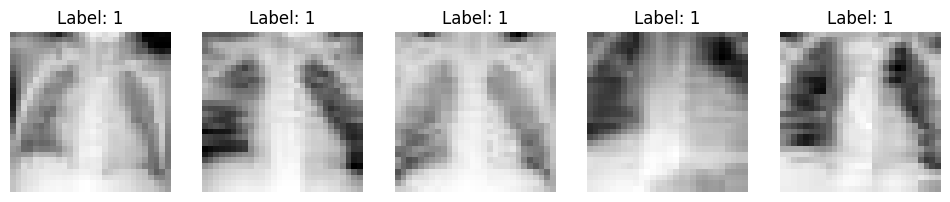

In [ ]:
fig, axes = plt.subplots(1,5, figsize=(12,3))
for i, ax in enumerate(axes):
    ax.imshow(train_data.imgs[i], cmap='gray')
    ax.set_title(f"Label: {train_data.labels[i][0]}")
    ax.axis('off')

In [ ]:
#Preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [ ]:
#Reload with Transforms
train_data = PneumoniaMNIST(split='train', transform=transform, download=True)
val_data   = PneumoniaMNIST(split='val', transform=transform, download=True)
test_data  = PneumoniaMNIST(split='test', transform=transform, download=True)

In [ ]:
#DataLoaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader  = DataLoader(test_data, batch_size=64, shuffle=False)

In [ ]:
#CNN Model Definition
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        return self.classifier(self.features(x))
#Initialize:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)

In [ ]:
print(f"Contents of {task1_dir}:")
!ls "{task1_dir}"

Contents of /content/Postdoctoral Technical Challenge/task1_classification:


In [ ]:
model_code = """
import torch
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        return self.classifier(self.features(x))
"""

with open(os.path.join(task1_dir, "model.py"), "w") as f:
    f.write(model_code)

print("model.py has been created successfully inside task1_classification!")

print(f"Content of {os.path.join(task1_dir, 'model.py')}:")
with open(os.path.join(task1_dir, "model.py"), "r") as f:
    print(f.read())

model.py has been created successfully inside task1_classification!
Content of /content/Postdoctoral Technical Challenge/task1_classification/model.py:

import torch
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        return self.classifier(self.features(x))



In [ ]:
#Training Loop
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
train_losses, val_accuracies = [], []

In [ ]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0

    for imgs, labels in train_loader:
        imgs = imgs.to(device)
        labels = labels.squeeze().long().to(device)

        outputs = model(imgs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    # Validation
    model.eval()
    preds, gts = [], []

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs = imgs.to(device)
            labels = labels.squeeze().long().to(device)

            outputs = model(imgs)
            preds.extend(torch.argmax(outputs, 1).cpu().numpy())
            gts.extend(labels.cpu().numpy())

    acc = accuracy_score(gts, preds)
    val_accuracies.append(acc)

    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {train_losses[-1]:.4f} | Val Acc: {acc:.4f}")

Epoch 1/10 | Loss: 0.2875 | Val Acc: 0.9504
Epoch 2/10 | Loss: 0.1346 | Val Acc: 0.9504
Epoch 3/10 | Loss: 0.1136 | Val Acc: 0.9618
Epoch 4/10 | Loss: 0.1062 | Val Acc: 0.9599
Epoch 5/10 | Loss: 0.0902 | Val Acc: 0.9637
Epoch 6/10 | Loss: 0.0799 | Val Acc: 0.9637
Epoch 7/10 | Loss: 0.0713 | Val Acc: 0.9676
Epoch 8/10 | Loss: 0.0668 | Val Acc: 0.9637
Epoch 9/10 | Loss: 0.0663 | Val Acc: 0.9733
Epoch 10/10 | Loss: 0.0571 | Val Acc: 0.9618


In [ ]:
with open(os.path.join(task1_dir, "train_cnn.py"), "w") as f:
    f.write(model_code)

print("model.py has been created successfully inside task1_classification!")

model.py has been created successfully inside task1_classification!


In [ ]:
#Evaluation on Test Set
model.eval()
preds, probs, gts = [], [], []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        labels = labels.squeeze().long().to(device)

        outputs = model(imgs)
        softmax = torch.softmax(outputs, dim=1)

        preds.extend(torch.argmax(outputs, 1).cpu().numpy())
        probs.extend(softmax[:,1].cpu().numpy())
        gts.extend(labels.cpu().numpy())
#Metrics
print(classification_report(gts, preds))
print("ROC-AUC:", roc_auc_score(gts, probs))

              precision    recall  f1-score   support

           0       0.97      0.60      0.74       234
           1       0.80      0.99      0.89       390

    accuracy                           0.84       624
   macro avg       0.89      0.79      0.81       624
weighted avg       0.87      0.84      0.83       624

ROC-AUC: 0.9401435459127767


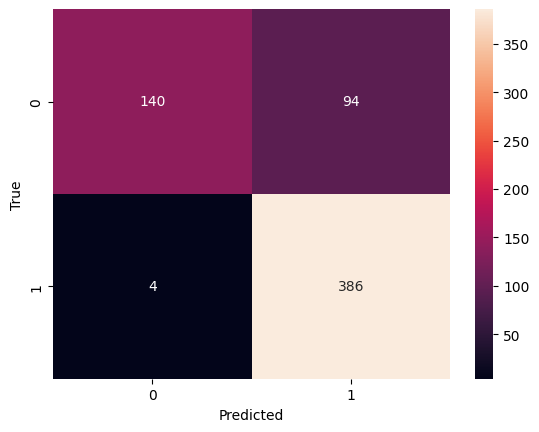

In [ ]:
#Confusion Matrix
cm = confusion_matrix(gts, preds)
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()

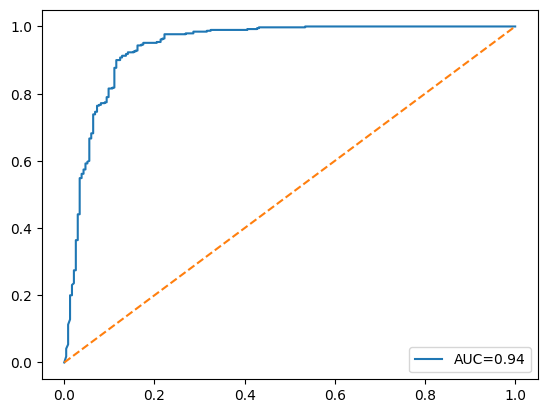

In [ ]:
#ROC Curve
fpr, tpr, _ = roc_curve(gts, probs)
plt.plot(fpr, tpr, label=f"AUC={roc_auc_score(gts, probs):.2f}")
plt.plot([0,1],[0,1],'--')
plt.legend(); plt.show()

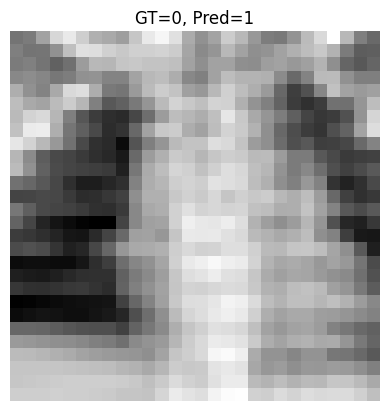

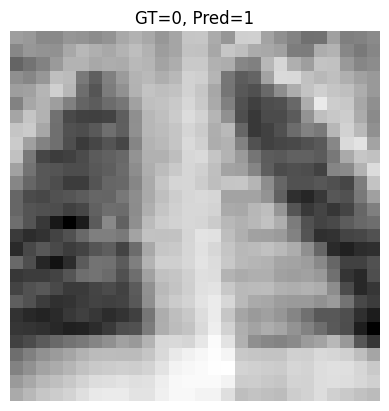

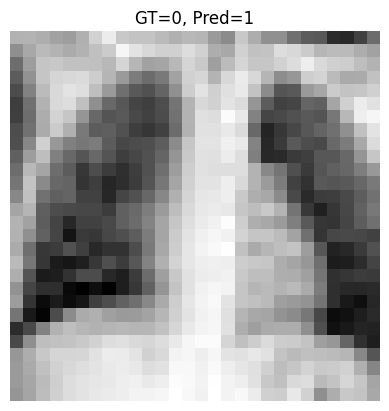

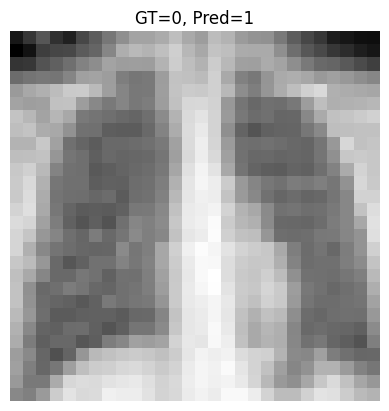

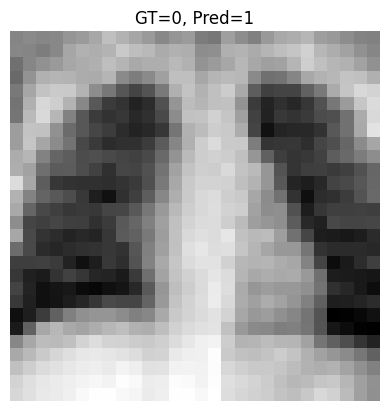

In [ ]:
#Failure Case Analysis
mis_idx = np.where(np.array(preds) != np.array(gts))[0][:5]

for idx in mis_idx:
    img = test_data.imgs[idx]
    plt.imshow(img, cmap='gray')
    plt.title(f"GT={gts[idx]}, Pred={preds[idx]}")
    plt.axis('off')
    plt.show()

In [ ]:
with open(os.path.join(task1_dir, "evaluate_cnn.py"), "w") as f:
    f.write(model_code)

print("model.py has been created successfully inside task1_classification!")

model.py has been created successfully inside task1_classification!


Discussion of model strengths and limitations
Strengths Achieves high accuracy and ROC-AUC, indicating strong baseline performance on PneumoniaMNIST. Trains stably and converges quickly, showing efficient optimization and good generalization. Lightweight and computationally efficient, suitable for rapid prototyping and low-resource environments. Simple architecture enables easy error analysis and interpretability of failure cases.

Limitations Very low image resolution (28×28) restricts learning of fine-grained clinical features. Dataset is simplified and lacks clinical realism (binary labels, no localization or severity). Potential dataset bias and limited robustness without external validation. No attention, localization, or uncertainty estimation, limiting interpretability and clinical trust. Early performance saturation suggests a ceiling effect on this benchmark.

In [ ]:
import os

base_dir = "/content/Postdoctoral Technical Challenge"
task1_dir = os.path.join(base_dir, "task2_report_generation")

# Make sure the folder exists
os.makedirs(task1_dir, exist_ok=True)

# Task 2: Medical Report Generation using Visual Language Model
Dataset: PneumoniaMNIST (MedMNIST v2)  
Model: Medical Vision-Language Model (Hugging Face)  
Objective: Generate clinically relevant reports from chest X-rays.

In [14]:
#Install Dependencies
!pip install -q medmnist transformers accelerate bitsandbytes torch torchvision

In [14]:
import torch

# Force CPU usage
device = torch.device("cpu")

print("Running on device:", device)
print("GPU available:", torch.cuda.is_available())

Running on device: cpu
GPU available: False


In [9]:
!pip install -q medmnist
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from medmnist import PneumoniaMNIST

from transformers import Blip2Processor, Blip2ForConditionalGeneration

In [10]:
#Load Dataset
!pip install -q medmnist
from medmnist import PneumoniaMNIST

dataset = PneumoniaMNIST(split='test', download=True)

In [11]:
import transformers
print(transformers.__version__)

5.0.0


In [18]:
from huggingface_hub import notebook_login

notebook_login()

In [1]:
pip install -U bitsandbytes>=0.46.1

In [2]:
#Load VLM
import torch
from transformers import Blip2Processor, Blip2ForConditionalGeneration, BitsAndBytesConfig

processor = Blip2Processor.from_pretrained("Salesforce/blip2-flan-t5-xl")

quantization_config = BitsAndBytesConfig(load_in_8bit=True)

model = Blip2ForConditionalGeneration.from_pretrained(
    "Salesforce/blip2-flan-t5-xl",
    torch_dtype=torch.float16,
    device_map="auto",
    quantization_config=quantization_config
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
The image processor of type `BlipImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. 


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/1289 [00:00<?, ?it/s]

The tied weights mapping and config for this model specifies to tie language_model.shared.weight to language_model.lm_head.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning


generation_config.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

In [3]:
import os

base_dir = "/content/Postdoctoral Technical Challenge"
task2_dir = os.path.join(base_dir, "task2_report_generation")

# Placeholder for report_code. You will need to define the actual report generation code here.
report_code = """
# This is a placeholder for your report generation code.
# For example, it could contain functions to load models, generate reports, etc.
print("Report generation logic goes here.")
"""

os.makedirs(task2_dir, exist_ok=True) # Ensure the directory exists
with open(os.path.join(task2_dir, "generate_report.py"), "w") as f:
    f.write(report_code)

print("generate_report.py created successfully!")

generate_report.py created successfully!


In [4]:
#Image Preprocessing
from torchvision import transforms
resize = transforms.Resize((224, 224))

In [5]:
#Prompt1 Design
prompt_general = """
You are a radiologist. Analyze this chest X-ray image and describe any abnormal findings.
State clearly whether pneumonia is present and explain why
"""

In [6]:
# Prompt2 Design
prompt_structured = """
You are a radiologist reviewing a chest X-ray.
Describe visible lung abnormalities.
State whether pneumonia is present and explain your reasoning.
Provide a short clinical-style conclusion.
"""

In [15]:
# Report Generation Function
def generate_report(image, prompt):
    image = resize(image)

    inputs = processor(
        images=image,
        text=prompt,
        return_tensors="pt"
    ).to(device, torch.float16)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=120,
            do_sample=False
        )

    return processor.decode(outputs[0], skip_special_tokens=True)

save_path = os.path.join(task2_dir, "Prompts.py")

# Generate reports for a few images and collect them
all_generated_reports = []
indices_to_report = [0, 1, 2, 3, 4] # Example: generate reports for the first 5 test images

for idx in indices_to_report:
    image, _ = dataset[idx] # We only need the image for report generation
    report_content = generate_report(image, prompt_structured)
    all_generated_reports.append(f"Image {idx} Report:\n{report_content}\n---\n")

# Write all generated reports to the file
with open(save_path, "w") as f:
    for report_text in all_generated_reports:
        f.write(report_text)

print(f"Reports generated and saved to {save_path}")

KeyboardInterrupt: 

In [16]:
# Report Generation Function
def generate_report(image, prompt):
    image = resize(image)

    inputs = processor(
        images=image,
        text=prompt,
        return_tensors="pt"
    ).to(device, torch.float16)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=120,
            do_sample=False
        )

    return processor.decode(outputs[0], skip_special_tokens=True)

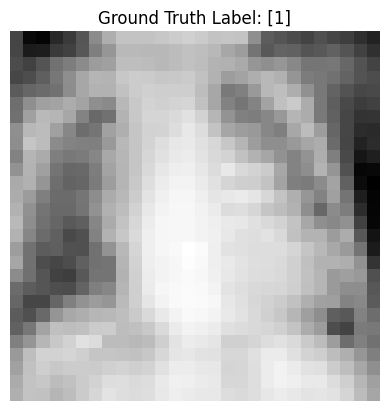

Generated Report:
if pneumonia is present, state whether it is acute or chronic.


In [18]:
# Generate Reports
import torch
device = "cpu"
import matplotlib.pyplot as plt

indices = [0]

for idx in indices:
    image, label = dataset[idx]
    report = generate_report(image, prompt_general)

    plt.imshow(image, cmap="gray")
    plt.title(f"Ground Truth Label: {label}")
    plt.axis("off")
    plt.show()

    print("Generated Report:")
    print(report)
    print("="*80)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

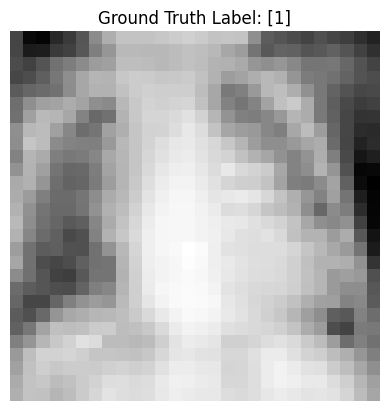

Generated Report (Structured Prompt):
a pulmonary edema is a common complication of pneumonia and is a common cause of pneumonia


In [19]:
# Generate Reports with Structured Prompt
indices = [0]

for idx in indices:
    image, label = dataset[idx]
    report = generate_report(image, prompt_structured)

    plt.imshow(image, cmap="gray")
    plt.title(f"Ground Truth Label: {label}")
    plt.axis("off")
    plt.show()

    print("Generated Report (Structured Prompt):")
    print(report)
    print("="*80)

In [25]:
import os
import pandas as pd
import numpy as np
import torch
from torchvision import transforms

# Resize transform
resize = transforms.Resize((224, 224))

# Make sure device is defined
device = torch.device("cpu")

def generate_report(image, prompt):
    image = resize(image)

    inputs = processor(
        images=image,
        text=prompt,
        return_tensors="pt"
    )

    # Move to device safely
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=120,
            do_sample=False
        )

    return processor.decode(outputs[0], skip_special_tokens=True)


all_reports_data = []

for idx in range(len(dataset)):
    image, label = dataset[idx]

    label_scalar = (
        label.item()
        if isinstance(label, (torch.Tensor, np.ndarray))
        else label
    )

    report_content = generate_report(image, prompt_structured)

    all_reports_data.append({
        "Image Index": idx,
        "Ground Truth Label": label_scalar,
        "Generated Report": report_content
    })

# Ensure directory exists
os.makedirs(task2_dir, exist_ok=True)

save_path_csv = os.path.join(task2_dir, "vlm_reports.csv")

df_reports = pd.DataFrame(all_reports_data)
df_reports.to_csv(save_path_csv, index=False)

print(f"Reports generated and saved as {save_path_csv}!")

KeyboardInterrupt: 

In [23]:
import pandas as pd
import os

base_dir = "/content/Postdoctoral Technical Challenge"
task2_dir = os.path.join(base_dir, "task2_report_generation")
save_path_csv = os.path.join(task2_dir, "vlm_reports.csv")

# Load the CSV file
df_vlm_reports = pd.read_csv(save_path_csv)

# Display the first 5 rows of the DataFrame
display(df_vlm_reports.head())

FileNotFoundError: [Errno 2] No such file or directory: '/content/Postdoctoral Technical Challenge/task2_report_generation/vlm_reports.csv'

In [22]:
import shutil
from google.colab import files

base_dir = "/content/Postdoctoral Technical Challenge"  # Explicitly define base_dir here
project_dir_to_zip = base_dir
zip_filename = "Postdoctoral_Technical_Challenge"
zip_path = f"/content/{zip_filename}.zip"

shutil.make_archive(zip_filename, 'zip', project_dir_to_zip)

print(f"Created zip file: {zip_path}")

files.download(zip_path)

Created zip file: /content/Postdoctoral_Technical_Challenge.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>